In [57]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from xgboost import XGBRegressor
from sklearn import preprocessing
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.linear_model import ElasticNetCV, LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.utils import check_array
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics import r2_score

In [31]:
class StackingEstimator(BaseEstimator):
    
    def __init__(self, estimator):
        self.estimator = estimator
        
    def fit(self, X, y=None, **fit_params):
        self.estimator.fit(X, y, **fit_params)
        return self
    
    def transform(self, X):
        X = check_array(X)
        X_transformed = np.copy(X)
        X_transformed = np.hstack((np.reshape(self.estimator.predict(X), (-1, 1)), X_transformed))
        return X_transformed

In [32]:
train = pd.read_csv("data/train.csv", index_col="ID")
test = pd.read_csv("data/test.csv", index_col="ID")

In [33]:
for c in train.columns:
    if train[c].dtype == "object":
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[c].values) + list(test[c].values))
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))

In [34]:
n_comp = 10

# PCA
pca = PCA(n_components=n_comp, random_state=42)
pca2_results_train = pca.fit_transform(train.drop(["y"], axis=1))
pca2_results_test = pca.transform(test)

# ICA
ica = FastICA(n_components=n_comp, random_state=42)
ica2_results_train = ica.fit_transform(train.drop(["y"], axis=1))
ica2_results_test = ica.transform(test)

In [35]:
y_train = train["y"].values
y_mean = np.mean(y_train)

In [37]:
stacked_pipeline = make_pipeline(
    StackingEstimator(estimator=LassoLarsCV(normalize=True)),
    StackingEstimator(estimator=XGBRegressor(
            n_estimators=700,
            learning_rate=0.005,
            max_depth=3,
            gamma=0.3,
            min_child_weight=6,
            subsample=0.8,
            colsample_bytree=0.65,
            objective="reg:linear",
            base_score=y_mean)),
    LassoLarsCV()
)

In [38]:
stacked_pipeline.fit(train.drop("y", axis=1), y_train)

/Users/datitran/anaconda/envs/kaggle/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.025e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/datitran/anaconda/envs/kaggle/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.597e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
/Users/datitran/anaconda/envs/kaggle/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/Users/datitran/anaconda/envs/kaggle/lib/python3.5/site-packages/sklearn/linear_model/least_ang

Pipeline(steps=[('stackingestimator-1', StackingEstimator(estimator=LassoLarsCV(copy_X=True, cv=None, eps=2.2204460492503131e-16,
      fit_intercept=True, max_iter=500, max_n_alphas=1000, n_jobs=1,
      normalize=True, positive=False, precompute='auto', verbose=False))), ('stackingestimator-2', StackingEst...x_n_alphas=1000, n_jobs=1,
      normalize=True, positive=False, precompute='auto', verbose=False))])

In [64]:
y_pred_train_stack = stacked_pipeline.predict(train.drop("y", axis=1))
print(r2_score(y_train, y_pred_train_stack))

0.592427725976


In [67]:
y_predict_stacked = stacked_pipeline.predict(test)

In [68]:
y_predict_stacked

array([  80.59707574,   96.32224718,   80.42610539, ...,   93.83742162,
        111.51937369,   93.46239439])

### XGBoost

In [53]:
xgb_params = XGBRegressor(n_estimators=700,
                    learning_rate=0.005,
                    max_depth=3,
                    gamma=0.3,
                    min_child_weight=6,
                    subsample=0.8,
                    colsample_bytree=0.65,
                    objective="reg:linear",
                    base_score=y_mean)

In [54]:
dtrain = xgb.DMatrix(train.drop("y", axis=1), y_train)
dtest = xgb.DMatrix(test)

In [55]:
cv_output = xgb.cv(xgb_params.get_params(), dtrain, num_boost_round=2000, early_stopping_rounds=50, 
                   verbose_eval=50, show_stdv=False)

[0]	train-rmse:12.6411	test-rmse:12.6384
[50]	train-rmse:11.1835	test-rmse:11.1891
[100]	train-rmse:10.1723	test-rmse:10.1908
[150]	train-rmse:9.49111	test-rmse:9.52495
[200]	train-rmse:9.04012	test-rmse:9.08874
[250]	train-rmse:8.7446	test-rmse:8.80755
[300]	train-rmse:8.55546	test-rmse:8.63224
[350]	train-rmse:8.42953	test-rmse:8.52163
[400]	train-rmse:8.3432	test-rmse:8.45131
[450]	train-rmse:8.28158	test-rmse:8.4066
[500]	train-rmse:8.23576	test-rmse:8.37736
[550]	train-rmse:8.19845	test-rmse:8.35889
[600]	train-rmse:8.16816	test-rmse:8.34559
[650]	train-rmse:8.14054	test-rmse:8.33755
[700]	train-rmse:8.1166	test-rmse:8.33257
[750]	train-rmse:8.09468	test-rmse:8.32906
[800]	train-rmse:8.07387	test-rmse:8.32693
[850]	train-rmse:8.05142	test-rmse:8.32566


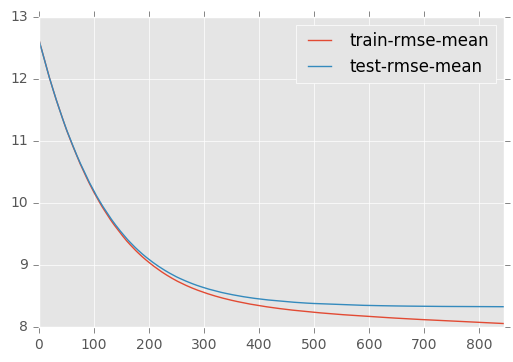

In [58]:
cv_output[["train-rmse-mean", "test-rmse-mean"]].plot()
pass

In [59]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params.get_params(), silent=0), dtrain, num_boost_round=num_boost_rounds)

In [60]:
y_pred_train = model.predict(dtrain)

In [61]:
r2_score(y_train, y_pred_train)

0.58835030279557965

In [69]:
y_predict_xgb = model.predict(dtest)

In [70]:
y_predict_xgb

array([  79.10256958,   94.28078461,   78.72685242, ...,   93.56414795,
        111.0569458 ,   93.46633911], dtype=float32)

### Need to do cross-validation for stack and xgb; in terms of r2_score

0.5 * xgb + 0.5 * stacked = test vs. test -> optimization problem; find x1 and x2 where it perfect

In [89]:
x1 = np.arange(0, 1.1, 0.1)
r2_values = []
for i in x1:
    r2_values.append(r2_score(y_train, i * y_pred_train_stack +  (1-i) * y_pred_train))

In [90]:
r2_values

[0.58835030279557965,
 0.58897325009065171,
 0.58954838249095798,
 0.59007568684877221,
 0.59055516760130478,
 0.59098682242286982,
 0.59137065136930589,
 0.59170665756415164,
 0.5919948379567157,
 0.5922351942874795,
 0.59242772597628257]

### Visualization

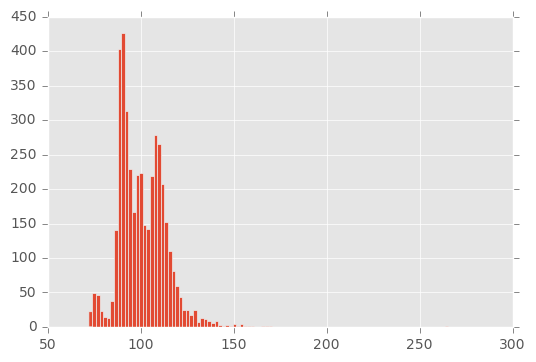

In [97]:
pd.Series(y_train).hist(bins=100)

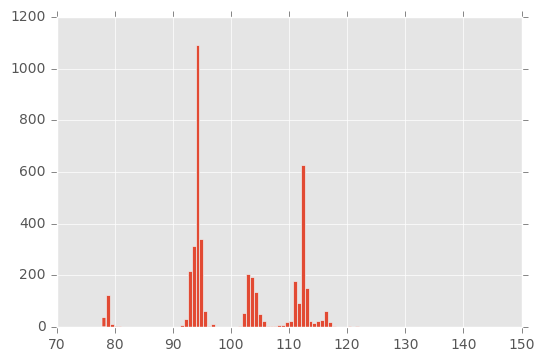

In [99]:
pd.Series(y_pred_train_stack).hist(bins=100)

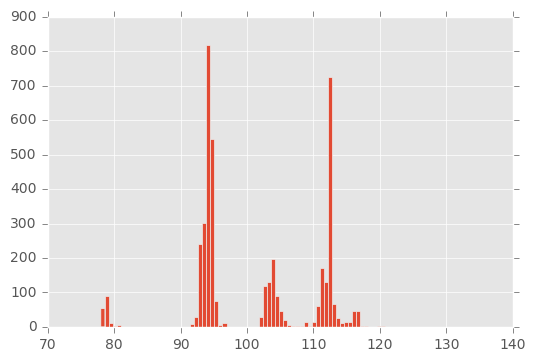

In [100]:
pd.Series(y_predict_stacked).hist(bins=100)

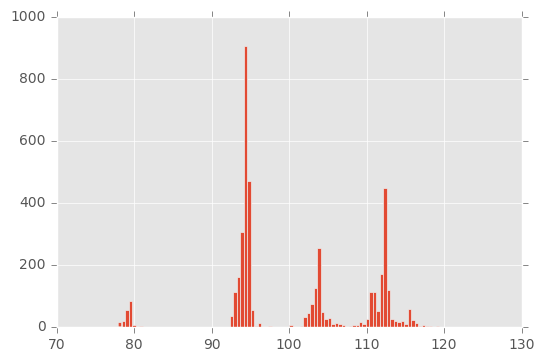

In [101]:
# xgboost normal
pd.Series(y_pred_train).hist(bins=100)

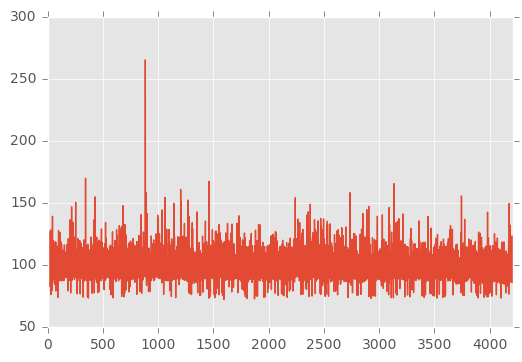

In [107]:
pd.Series(y_train).plot()

### Output

In [129]:
weight = 0.2
y_predict_combined = weight * y_predict_stacked + (1-weight) * y_predict_xgb

In [130]:
output = pd.DataFrame({"ID": test.index, "y": y_predict_combined})

In [132]:
output.to_csv("submissions_stacked_combined.csv", index=False)